In [1535]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [1536]:
data = pd.read_csv('car_data.csv')
data.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0


In [1537]:
le = LabelEncoder()
mms = MinMaxScaler()
data['Age'] = mms.fit_transform(data[['Age']])
data['AnnualSalary'] = mms.fit_transform(data[['AnnualSalary']])
data = data.drop(columns=['User ID'])
data = data.drop(columns=['Gender'])
data.head()

,Age,AnnualSalary,Purchased
0,0.377778,0.036364,0
1,0.488889,0.207273,0
2,0.688889,0.429091,0
3,0.488889,0.672727,1
4,0.155556,0.465455,0


In [1538]:
TARGET_KEY = 'Purchased'
X_data, y_data = data.drop(columns=[TARGET_KEY]), data[[TARGET_KEY]]
X_test, X_train, y_test, y_train = train_test_split(X_data, y_data)
X_train[TARGET_KEY] = y_train
train_data = X_train
DATA_COLUMNS = [col for col in train_data]
train_data

,Age,AnnualSalary,Purchased
99,0.444444,0.330909,0
766,0.377778,0.414545,0
802,0.933333,0.345455,1
613,0.155556,0.098182,0
406,0.488889,0.363636,0
...,...,...,...
619,0.044444,0.429091,0
968,0.022222,0.498182,0
432,0.444444,0.363636,0
639,0.133333,0.538182,0


In [1539]:
def dist(p: np.ndarray, q: np.ndarray):
    return math.sqrt(sum([(pv - qv) ** 2 for pv, qv in zip(p, q)]))

def plot_neighbours(X: pd.Series, neighbours: pd.DataFrame):
    X_df = pd.DataFrame(X).T
    X_df[TARGET_KEY] = -1
    axis_couples = []
    for i in range(len(DATA_COLUMNS) - 1):
        for j in range(i + 1, len(DATA_COLUMNS) - 1):
            axis_couples += [(DATA_COLUMNS[i], DATA_COLUMNS[j])]
    for x1, x2 in axis_couples:
        fig, ax = plt.subplots()
        sns.scatterplot(ax=ax, x=x1, y=x2, data=neighbours, hue=TARGET_KEY, palette=['#0000ff', '#ff0000'])
        sns.scatterplot(ax=ax, x=x1, y=x2, data=X_df, hue=TARGET_KEY, palette=['#000000'], marker='X', s=200)

def get_neighbors(K: int, X: pd.Series):
    X_array = X.to_numpy()        
    return pd.DataFrame.from_records(sorted(train_data.to_numpy(), key=lambda x: dist(x[:-1], X_array))[0:K], columns=DATA_COLUMNS)

def predict_one(X: pd.Series, neighbours: pd.DataFrame):
    neighbours = [(dist(val[:-1], X.to_numpy()), val[-1]) for val in neighbours.to_numpy()]
    unique, counts = np.unique([val[1] for val in neighbours], return_counts=True)
    return sorted(np.c_[unique, counts], key=lambda x: x[1])[-1][0]


/tmp/ipykernel_13676/4190160992.py:13: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(ax=ax, x=x1, y=x2, data=neighbours, hue=TARGET_KEY, palette=['#0000ff', '#ff0000'])


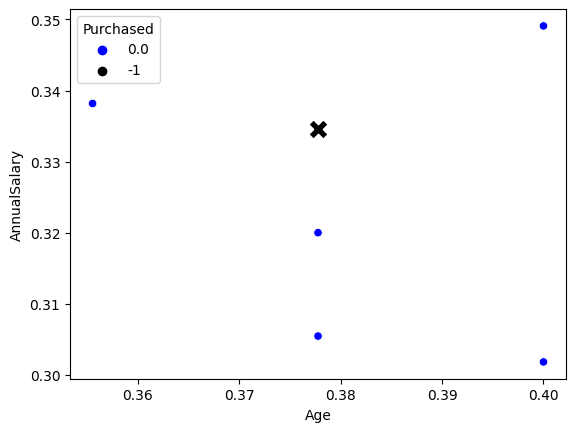

In [1540]:
X_neighbours = []

for index, X in X_test.iterrows():
    neighbours = get_neighbors(5, X)
    X_neighbours += [(X, neighbours)]

plot_neighbours(X_neighbours[0][0], X_neighbours[0][1])

In [1541]:
pred = predict_one(X_neighbours[0][0], X_neighbours[0][1])
pred

0.0

In [1542]:
pred = pd.DataFrame(columns=DATA_COLUMNS)
for X, neighbours in X_neighbours:
    X[f'{TARGET_KEY}_pred'] = predict_one(X, neighbours)
    pred = pred.append(X)
pred[TARGET_KEY] = y_test

/tmp/ipykernel_13676/3461003988.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred = pred.append(X)
/tmp/ipykernel_13676/3461003988.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred = pred.append(X)
/tmp/ipykernel_13676/3461003988.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred = pred.append(X)
/tmp/ipykernel_13676/3461003988.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred = pred.append(X)
/tmp/ipykernel_13676/3461003988.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred = pred.append(X)
/tmp/ipykernel_13676/3461

In [1543]:
pred.head()

,Age,AnnualSalary,Purchased,Purchased_pred
118,0.377778,0.334545,0,0.0
293,0.644444,0.232727,0,1.0
986,0.666667,0.130909,1,1.0
203,0.511111,0.472727,0,0.0
800,0.622222,0.123636,1,1.0


In [1544]:
count = len(pred)
count_true = 0
index = 0
for index, X in pred.iterrows():
    if X[TARGET_KEY] == X[f'{TARGET_KEY}_pred']:
        count_true += 1
accuracy_manual = count_true / count
accuracy_manual

0.8853333333333333

In [1545]:
knn = KNeighborsClassifier()
k_range = list(range(1, 30))
param_grid = dict(n_neighbors=k_range)

rnd = RandomizedSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)

random_search=rnd.fit(X_train.to_numpy(), y_train.to_numpy().flatten())
best_K = random_search.best_params_['n_neighbors']
best_K

21

In [1546]:
X_neighbours = []

for index, X in X_test.iterrows():
    neighbours = get_neighbors(best_K, X)
    X_neighbours += [(X, neighbours)]

pred = pd.DataFrame(columns=DATA_COLUMNS)
for X, neighbours in X_neighbours:
    X[f'{TARGET_KEY}_pred'] = predict_one(X, neighbours)
    pred = pred.append(X)
pred[TARGET_KEY] = y_test

count = len(pred)
count_true = 0
index = 0
for index, X in pred.iterrows():
    if X[TARGET_KEY] == X[f'{TARGET_KEY}_pred']:
        count_true += 1
accuracy_rs = count_true / count
accuracy_rs

/tmp/ipykernel_13676/2174680328.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred = pred.append(X)
/tmp/ipykernel_13676/2174680328.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred = pred.append(X)
/tmp/ipykernel_13676/2174680328.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred = pred.append(X)
/tmp/ipykernel_13676/2174680328.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred = pred.append(X)
/tmp/ipykernel_13676/2174680328.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred = pred.append(X)
/tmp/ipykernel_13676

0.912